In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [ ]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [ ]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [ ]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
def build_1d_cnn_custom_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(BatchNormalization())
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [ ]:
for i in range(1, 10):
    model = build_1d_cnn_custom_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 4096000)           16384000  
_________________________________________________________________
dense (Dense)                (None, 16)                65536016  
Total params: 81,922,576
Trainable params: 73,730,064
Non-trainable pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_20 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_21 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_44 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5479 - acc: 0.5283
Epoch 00001: val_loss improved from inf to 1.30350, saving model to model/checkpoint/1D_CNN_custom_2_BN_6_conv_checkpoint/001-1.3035.hdf5
36805/36805 [==============================] - 430s 12ms/sample - loss: 1.5484 - acc: 0.5282 - val_loss: 1.3035 - val_acc: 0.5959
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9508 - acc: 0.7198
Epoch 00002: val_loss improved from 1.30350 to 0.87471, saving model to model/checkpoint/1D_CNN_custom_2_BN_6_conv_checkpoint/002-0.8747.hdf5
36805/36805 [==============================] - 424s 12ms/sample - loss: 0.9509 - acc: 0.7198 - val_loss: 0.8747 - val_acc: 0.7424
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7592 - acc: 0.7794
Epoch 00003: val_loss improved from 0.87471 to 0.72946, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.0479 - acc: 0.9912
Epoch 00026: val_loss did not improve from 0.49751
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.0479 - acc: 0.9912 - val_loss: 0.5134 - val_acc: 0.8735
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9879
Epoch 00027: val_loss did not improve from 0.49751
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.0542 - acc: 0.9878 - val_loss: 0.6578 - val_acc: 0.8444
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9832
Epoch 00028: val_loss did not improve from 0.49751
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.0681 - acc: 0.9832 - val_loss: 0.5068 - val_acc: 0.8796
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0614 - acc: 0.9855
Epoch 00029: val_loss did not improve from 0.49751
36805/36805 [==================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9954
Epoch 00055: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0214 - acc: 0.9954 - val_loss: 0.6230 - val_acc: 0.8712
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9926
Epoch 00056: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0324 - acc: 0.9926 - val_loss: 0.5180 - val_acc: 0.8868
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9975
Epoch 00057: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0164 - acc: 0.9975 - val_loss: 0.5114 - val_acc: 0.8949
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9979
Epoch 00058: val_loss did not improve from 0.46785
36805/36805 [==================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9983
Epoch 00085: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0116 - acc: 0.9982 - val_loss: 0.6337 - val_acc: 0.8754
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9929
Epoch 00086: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0287 - acc: 0.9928 - val_loss: 0.5575 - val_acc: 0.8896
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9956
Epoch 00087: val_loss did not improve from 0.46785
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0193 - acc: 0.9956 - val_loss: 0.5674 - val_acc: 0.8842
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9981
Epoch 00088: val_loss did not improve from 0.46785
36805/36805 [=====

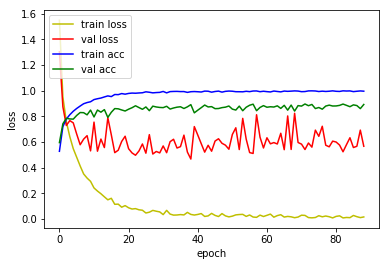

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.5702 - acc: 0.8629
Loss: 0.5701692538345591 Accuracy: 0.86292833

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5988 - acc: 0.5150
Epoch 00001: val_loss improved from inf to 1.33071, saving model to model/checkpoint/1D_CNN_custom_2_BN_7_conv_checkpoint/001-1.3307.hdf5
36805/36805 [==============================] - 434s 12ms/sample - loss: 1.5988 - acc: 0.5150 - val_loss: 1.3307 - val_acc: 0.5889
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8878 - acc: 0.7412
Epoch 00002: val_loss improved from 1.33071 to 0.83290, saving model to model/checkpoint/1D_CNN_custom_2_BN_7_conv_checkpoint/002-0.8329.hdf5
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.8879 - acc: 0.7411 - val_loss: 0.8329 - val_acc: 0.7482
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6505 -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9942
Epoch 00026: val_loss improved from 0.24281 to 0.23351, saving model to model/checkpoint/1D_CNN_custom_2_BN_7_conv_checkpoint/026-0.2335.hdf5
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0349 - acc: 0.9942 - val_loss: 0.2335 - val_acc: 0.9385
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9942
Epoch 00027: val_loss did not improve from 0.23351
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0322 - acc: 0.9942 - val_loss: 0.2620 - val_acc: 0.9280
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9905
Epoch 00028: val_loss did not improve from 0.23351
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0412 - acc: 0.9904 - val_loss: 0.3340 - val_acc: 0.9096
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss:

In [ ]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')

In [ ]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')